# PerceptNet

In this notebook we will be loading the TID2013 dataset and using it to train our PerceptNet model.

They way it is stored in the system is the following:

- The original images are in `reference_images/`.
- The distorted images are named as: `<img_name>_<distortion_numer>_<distortion_intensity>`.
- Metris are stored in `metrics_values/` as `.txt` files pairing the original and distorted images by file name.

## Importing libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
from glob import glob
import cv2

from GDN_Jorge import GDN as GDNJ

## Loading the data

In [3]:
path = '/media/disk/databases/BBDD_video_image/Image_Quality/TID/TID2013'

In [4]:
len(glob(os.path.join(path, 'distorted_images', '*.bmp')))

3000

In [5]:
len(glob(os.path.join(path, 'reference_images', '*.BMP')))

25

We load the filename-metric pairs:

In [6]:
name_metric = {}
with open(os.path.join(path, 'mos_with_names.txt')) as f:
    for line in f.readlines():
        # remove last character to avoid \n
        metric, file_name = line[:-1].split(" ")
        name_metric[file_name.lower().split(".")[0]] = float(metric)

Fetch the image names with glob and turn all of them to lowercase:

In [7]:
from collections import namedtuple

We create a `namedtuple` to make the code cleaner:

In [8]:
ImagePair = namedtuple('ImagePair', 'img_path dist_img_path metric')

In [9]:
data = []
for img_path in glob(os.path.join(path, 'reference_images', '*.BMP')):
    # img_path = img_path.lower()
    for dist_img_path in glob(os.path.join(path, 'distorted_images', f'{img_path.lower().split("/")[-1].split(".")[0]}*')):
        data.append(ImagePair(img_path, dist_img_path, name_metric[dist_img_path.split("/")[-1].split(".")[0]]))
    #     break
    # break

In [10]:
data[0]

ImagePair(img_path='/media/disk/databases/BBDD_video_image/Image_Quality/TID/TID2013/reference_images/I13.BMP', dist_img_path='/media/disk/databases/BBDD_video_image/Image_Quality/TID/TID2013/distorted_images/i13_18_2.bmp', metric=3.74419)

We can easily turn this list into a generator that loads each image only when is needed:

In [11]:
def test_gen():
    for sample in data:
        img = cv2.imread(sample.img_path)
        dist_img = cv2.imread(sample.dist_img_path)
        metric = sample.metric
        yield img, dist_img, metric

In [12]:
a_shapes, b_shapes = [], []
for a, b, c in test_gen():
    a_shapes.append(a.shape)
    b_shapes.append(b.shape)
    break

We can check that all the images have the same shape:

In [13]:
from collections import Counter

In [14]:
Counter(a_shapes)

Counter({(384, 512, 3): 1})

In [15]:
Counter(b_shapes)

Counter({(384, 512, 3): 1})

And we can plot a pair to see them:

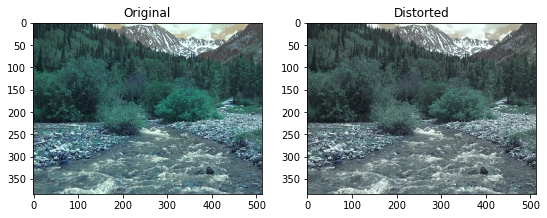

In [16]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(a)
plt.subplot(1,2,2)
plt.title("Distorted")
plt.imshow(b)
plt.show()

And finally, we turn this generator into a `tf.data.Dataset`:

In [17]:
dataset = tf.data.Dataset.from_generator(test_gen,
                                         output_signature=(
                                             tf.TensorSpec(shape=(384, 512, 3), dtype=tf.float32),
                                             tf.TensorSpec(shape=(384, 512, 3), dtype=tf.float32),
                                             tf.TensorSpec(shape=(), dtype=tf.float32)
                                         ))

2022-03-21 14:19:35.189753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10646 MB memory:  -> device: 0, name: Tesla K40m, pci bus id: 0000:03:00.0, compute capability: 3.5


In [18]:
for a, b, c in dataset:
    break

2022-03-21 14:19:35.501070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Using specific distortions or images

To perform some preliminar experiments, we could try to train our model with only one image and all of its distortions. This means we have to modify the way we load te data to accept this. We could have 3 scenarios:

- Working with only one image and its distortions: images are recognized by its name, which is the first thing in the filenames. Note that we have 120 variations of every image.

- Working with every image but only a subset of distortions: We could filter by the second element in the filenames, as it accounts for the distortion number. Note that we have 5 intensities for every distortion and we have 25 images, so for a single distortion we should have 125 images.

- Working with specific distortion intensities: We should filter by the last element in the filenames. Note that there are 24 distortions per image, so for a single intensity we should have 600 images.

The idea is to generalize the data loading process in a way that allows for quick experimentation, so we should allow the three posibilities in our pipeline.

### Filtering images

We'll start by filtering for specific images because it feels easier and will allow for a quick testing for our model, as it should generalize better to images than to distortions:

In [19]:
def filter_data(img_ids='all', ):
    """
    Filters the data to only utilize a subset based on img_id.

    Parameters
    ----------
    img_ids: list[string]
        List of image IDs to use passed as strings.
    
    Returns
    -------
    data: list[ImagePair]
        List of ImagePair objects containing the paths to the image pairs and 
        their corresponding metric.
    """
    data = []
    for img_path in glob(os.path.join(path, 'reference_images', '*.BMP')):
        if img_ids != 'all': # We only want to skip images if any ids were specified
            if img_path.lower().split("/")[-1].split(".")[0][1:] not in img_ids:
                continue # Skips this loop iteration if the ids is not being selected
        for dist_img_path in glob(os.path.join(path, 'distorted_images', f'{img_path.lower().split("/")[-1].split(".")[0]}*')):
            data.append(ImagePair(img_path, dist_img_path, name_metric[dist_img_path.split("/")[-1].split(".")[0]]))
    return data

### Filtering distortions

This shouldn't be much different from filtering images, but we'll see:

In [20]:
def filter_data(dist_ids='all'):
    """
    Filters the data to only utilize a subset based on dist_ids.

    Parameters
    ----------
    dist_ids: list[string]
        List of image IDs to use passed as strings.
    
    Returns
    -------
    data: list[ImagePair]
        List of ImagePair objects containing the paths to the image pairs and 
        their corresponding metric.
    """
    data = []
    for img_path in glob(os.path.join(path, 'reference_images', '*.BMP')):
        for dist_img_path in glob(os.path.join(path, 'distorted_images', f'{img_path.lower().split("/")[-1].split(".")[0]}*')):
            if dist_ids!='all':
                if dist_img_path.lower().split("/")[-1].split(".")[0][1:].split("_")[1] not in dist_ids:
                    continue
            data.append(ImagePair(img_path, dist_img_path, name_metric[dist_img_path.split("/")[-1].split(".")[0]]))
    return data

### Filtering distortion intensity

This shouldn't be much different from filtering images, but we'll see:

In [21]:
def filter_data(dist_int='all'):
    """
    Filters the data to only utilize a subset based on dist_int.

    Parameters
    ----------
    dist_int: list[string]
        List of image IDs to use passed as strings.
        As of now, the intensities go from 1 to 5.
    
    Returns
    -------
    data: list[ImagePair]
        List of ImagePair objects containing the paths to the image pairs and 
        their corresponding metric.
    """
    data = []
    for img_path in glob(os.path.join(path, 'reference_images', '*.BMP')):
        for dist_img_path in glob(os.path.join(path, 'distorted_images', f'{img_path.lower().split("/")[-1].split(".")[0]}*')):
            if dist_int!='all':
                if dist_img_path.lower().split("/")[-1].split(".")[0][1:].split("_")[2] not in dist_int:
                    continue
            data.append(ImagePair(img_path, dist_img_path, name_metric[dist_img_path.split("/")[-1].split(".")[0]]))
    return data

### Putting it all together

Now that we have been able to filter for each feature independently, we should create a generic function that allows us to filter the data as much as we want:

In [22]:
def filter_data(img_ids='all', 
                dist_ids='all',
                dist_ints='all'):
    """
    Filters the data to only utilize a subset based on img_id.

    Parameters
    ----------
    img_ids: list[string]
        List of image IDs to use passed as strings.
    dist_ids: list[string]
        List of image IDs to use passed as strings.
    dist_int: list[string]
        List of image IDs to use passed as strings.
        As of now, the intensities go from 1 to 5.
    
    Returns
    -------
    data: list[ImagePair]
        List of ImagePair objects containing the paths to the image pairs and 
        their corresponding metric.
    """
    data = []
    for img_path in glob(os.path.join(path, 'reference_images', '*.BMP')):
        if img_ids != 'all': # We only want to skip images if any ids were specified
            if img_path.lower().split("/")[-1].split(".")[0][1:] not in img_ids:
                continue # Skips this loop iteration if the ids is not being selected
        for dist_img_path in glob(os.path.join(path, 'distorted_images', f'{img_path.lower().split("/")[-1].split(".")[0]}*')):
            dist_id, dist_int = dist_img_path.lower().split("/")[-1].split(".")[0][1:].split("_")[1:]
            
            if dist_ids!='all':
                if dist_id not in dist_ids:
                    continue
            if dist_ints!='all':
                if dist_int not in dist_ints:
                    continue
            
            data.append(ImagePair(img_path, dist_img_path, name_metric[dist_img_path.split("/")[-1].split(".")[0]]))
    return data

In [23]:
# Test loading the whole dataset
assert len(filter_data()) == 3000

# Test filtering per img_ids
assert len(filter_data(img_ids=["16"])) == 120
assert len(filter_data(img_ids=["16", "17"])) == 240
assert len(filter_data(img_ids=["16", "17", "18"])) == 360

# Test filtering per dist_ids
assert len(filter_data(dist_ids=["16"])) == 125
assert len(filter_data(dist_ids=["16", "17"])) == 250
assert len(filter_data(dist_ids=["16", "17", "18"])) == 375

# Test filtering per dist_ints
assert len(filter_data(dist_ints=["1"])) == 600
assert len(filter_data(dist_ints=["1", "2"])) == 1200
assert len(filter_data(dist_ints=["1", "2", "3"])) == 1800

# Test mixing filters
assert len(filter_data(img_ids=["16"], dist_ids=["16"], dist_ints=["1"])) == 1
assert len(filter_data(img_ids=["16"], dist_ids=["16"], dist_ints="all")) == 5
assert len(filter_data(img_ids=["16"], dist_ids=["16", "17"], dist_ints=["2", "3"])) == 4

After all the testing we can be, at least, a little bit confident in our function.

## Excluding samples

In order to properly divide our data in training and testing subsets, we will need the posibility to exclude `img_ids`, `dist_ids` and `dist_ints`:

In [57]:
def filter_data(img_ids='all', 
                dist_ids='all',
                dist_ints='all',
                exclude_img_ids=None,
                exclude_dist_ids=None,
                exclude_dist_ints=None):
    """
    Filters the data to only utilize a subset based on img_id.

    Parameters
    ----------
    img_ids: list[string]
        List of image IDs to use passed as strings.
    dist_ids: list[string]
        List of image IDs to use passed as strings.
    dist_int: list[string]
        List of image IDs to use passed as strings.
        As of now, the intensities go from 1 to 5.
    exclude_img_ids: list[string]
        List of image IDs to exclude passed as strings.
    exclude_dist_ids: list[string]
        List of image IDs to exclude passed as strings.
    exclude_dist_int: list[string]
        List of image IDs to exclude passed as strings.
        As of now, the intensities go from 1 to 5.

    Returns
    -------
    data: list[ImagePair]
        List of ImagePair objects containing the paths to the image pairs and 
        their corresponding metric.
    """
    ## It's not good practice to default a parameter as an empty list.
    ## The good practice is to default it as a None and then create the empty list.
    exclude_img_ids = [] if exclude_img_ids == None else exclude_img_ids
    exclude_dist_ids = [] if exclude_dist_ids == None else exclude_dist_ids
    exclude_dist_ints = [] if exclude_dist_ints == None else exclude_dist_ints
    data = []
    for img_path in glob(os.path.join(path, 'reference_images', '*.BMP')):
        if img_ids != 'all': # We only want to skip images if any ids were specified
            if img_path.lower().split("/")[-1].split(".")[0][1:] not in img_ids:
                continue # Skips this loop iteration if the ids is not being selected
        elif len(exclude_img_ids)>0:
            if img_path.lower().split("/")[-1].split(".")[0][1:] in exclude_img_ids:
                continue
        for dist_img_path in glob(os.path.join(path, 'distorted_images', f'{img_path.lower().split("/")[-1].split(".")[0]}*')):
            dist_id, dist_int = dist_img_path.lower().split("/")[-1].split(".")[0][1:].split("_")[1:]
            
            if dist_ids!='all':
                if dist_id not in dist_ids:
                    continue
            elif len(exclude_dist_ids)>0:
                if dist_id in exclude_dist_ids:
                    continue
            if dist_ints!='all':
                if dist_int not in dist_ints:
                    continue
            elif len(exclude_dist_ints)>0:
                if dist_int in exclude_dist_ints:
                    continue
            
            data.append(ImagePair(img_path, dist_img_path, name_metric[dist_img_path.split("/")[-1].split(".")[0]]))
    return data

In [65]:
# Test loading the whole dataset
assert len(filter_data()) == 3000

# Test filtering per img_ids
assert len(filter_data(img_ids=["16"])) == 120
assert len(filter_data(img_ids=["16", "17"])) == 240
assert len(filter_data(img_ids=["16", "17", "18"])) == 360

# Test filtering per dist_ids
assert len(filter_data(dist_ids=["16"])) == 125
assert len(filter_data(dist_ids=["16", "17"])) == 250
assert len(filter_data(dist_ids=["16", "17", "18"])) == 375

# Test filtering per dist_ints
assert len(filter_data(dist_ints=["1"])) == 600
assert len(filter_data(dist_ints=["1", "2"])) == 1200
assert len(filter_data(dist_ints=["1", "2", "3"])) == 1800

# Test mixing filters
assert len(filter_data(img_ids=["16"], dist_ids=["16"], dist_ints=["1"])) == 1
assert len(filter_data(img_ids=["16"], dist_ids=["16"], dist_ints="all")) == 5
assert len(filter_data(img_ids=["16"], dist_ids=["16", "17"], dist_ints=["2", "3"])) == 4

# Test excluding
assert len(filter_data(exclude_img_ids=['16'])) == 3000-120
assert len(filter_data(exclude_dist_ids=['16'])) == 3000-125
assert len(filter_data(exclude_dist_ints=['1'])) == 3000-600
# assert len(filter_data(exclude_img_ids=['16'], exclude_dist_ids=['16'])) == 3000-120-125
# assert len(filter_data(exclude_dist_ids=['16'], exclude_dist_ints=['1'])) == 3000-125-600
# assert len(filter_data(exclude_img_ids=['16'], exclude_dist_ids=['16'], exclude_dist_ints=['1'])) == 3000-120-125-600

## Define loss function

PerceptNet is trained to maximize the Pearson correlation coefficient between the MOS and the L2 distance of the two images in the transformed domain, so we'll now define a custom loss function inhereting from `tf.keras.losses.Loss`:

In [24]:
class PearsonCorrelation(tf.keras.losses.Loss):
    """
    Loss used to train PerceptNet. Is calculated as the 
    Pearson Correlation Coefficient for a sample.
    """

    def call(self, y_true, y_pred):
        y_true_mean = tf.reduce_mean(y_true, axis=0)
        y_pred_mean = tf.reduce_mean(y_pred, axis=0)
        num = y_true-y_true_mean
        num *= y_pred-y_pred_mean
        num = tf.reduce_sum(num)
        denom = tf.sqrt(tf.reduce_sum((y_true-y_true_mean)**2))
        denom *= tf.sqrt(tf.reduce_sum((y_pred-y_pred_mean)**2))
        return num/denom

## Define PerceptNet

We might need to define PerceptNet as an inhereted model to be able to manage the `train_step` properly:

In [25]:
class PerceptNet(tf.keras.Model):
    def __init__(self):
        super(PerceptNet, self).__init__()
        self.model = tf.keras.Sequential([
            GDNJ(kernel_size=1, apply_independently=True, kernel_initializer="zeros"),
            layers.Conv2D(filters=3, kernel_size=1, strides=1, padding='same'),
            layers.MaxPool2D(2),
            GDNJ(kernel_size=1, kernel_initializer="zeros"),
            layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same'),
            layers.MaxPool2D(2),
            GDNJ(kernel_size=1, kernel_initializer="zeros"),
            layers.Conv2D(filters=128, kernel_size=5, strides=1, padding='same'),
            GDNJ(kernel_size=1, kernel_initializer="zeros")
        ])
    
    def call(self, X):
        return self.model(X)

    def train_step(self, data):
        """
        X: tuple (Original Image, Distorted Image)
        Y: float (MOS score)
        """
        img, dist_img, mos = data
        with tf.GradientTape() as tape:
            features_original = self(img)
            features_distorted = self(dist_img)
            l2 = (features_original-features_distorted)**2
            l2 = tf.reduce_sum(l2, axis=[1,2,3])
            l2 = tf.sqrt(l2)
            loss = -self.compiled_loss(mos, l2) # We want to maximize the Pearson Correlation, so we negate it
            # loss = tf.reduce_mean(loss) # Should be needed as the PearsonCorrelation already gives only one number

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {'pearson':loss}


### Build the `tf.data.Dataset`

In [26]:
data = filter_data(img_ids="all",
                   dist_ids="all",
                   dist_ints='all')
len(data)

3000

In [44]:
def test_gen():
    for sample in data:
        img = cv2.imread(sample.img_path)/255.0
        dist_img = cv2.imread(sample.dist_img_path)/255.0
        metric = 10-sample.metric # Higher mos should be less distance
        yield img, dist_img, metric

In [45]:
dataset = tf.data.Dataset.from_generator(test_gen,
                                         output_signature=(
                                             tf.TensorSpec(shape=(384, 512, 3), dtype=tf.float32),
                                             tf.TensorSpec(shape=(384, 512, 3), dtype=tf.float32),
                                             tf.TensorSpec(shape=(), dtype=tf.float32)
                                         ))

In [42]:
metrics = []
for a, b, c in dataset:
    metrics.append(c.numpy())

In [43]:
np.max(metrics), np.min(metrics)

(7.21429, 0.24242)

In [ ]:
metrics_mean = np.mean(metrics)
metrics_std = np.std(metrics)

In [ ]:
def standarize_metric(x, y, z):
    return x, y, (z-metrics_mean)/metrics_std

In [ ]:
dataset_std = dataset.map(standarize_metric)

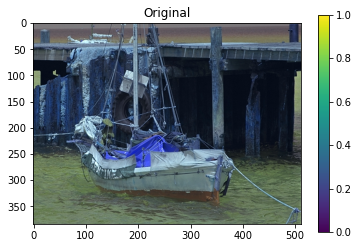

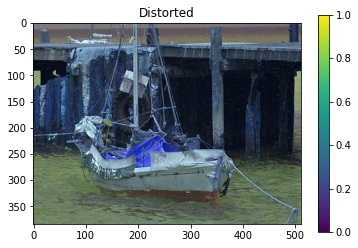

In [30]:
plt.figure()
plt.title("Original")
plt.imshow(a.numpy())
plt.colorbar()
plt.show()

plt.figure()
plt.title("Distorted")
plt.imshow(b.numpy())
plt.colorbar()
plt.show()

In [46]:
model = PerceptNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss=PearsonCorrelation())

In [47]:
history = model.fit(dataset.shuffle(buffer_size=24,
                                    reshuffle_each_iteration=True,
                                    seed=42)\
                            .batch(64, drop_remainder=True), epochs=5)

Epoch 1/5
46/46 [==============================] - 88s 2s/step - pearson: -0.7770
Epoch 2/5
46/46 [==============================] - 85s 2s/step - pearson: -0.8107
Epoch 3/5
46/46 [==============================] - 86s 2s/step - pearson: -0.8202
Epoch 4/5
46/46 [==============================] - 86s 2s/step - pearson: -0.8268
Epoch 5/5
46/46 [==============================] - 85s 2s/step - pearson: -0.8288


In [57]:
history.history

{'pearson': [-0.8299331665039062,
  -0.856463611125946,
  -0.8587027788162231,
  -0.8462116718292236,
  -0.7921593189239502]}

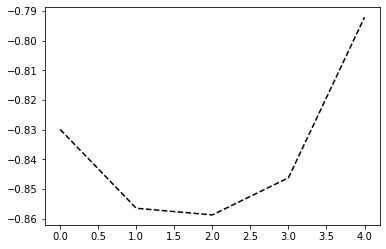

In [48]:
plt.figure()
plt.plot(history.history['pearson'], '--k')
plt.show()

In [49]:
mos_pred = []
for a, b, c in dataset.batch(64):
    features_original = model.predict(a)
    features_distorted = model.predict(b)
    l2 = (features_original-features_distorted)**2
    l2 = tf.reduce_sum(l2, axis=[1,2,3])
    l2 = tf.sqrt(l2)
    # loss = -PearsonCorrelation()(c, l2)
    break

In [50]:
l2

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 6.9165606,  9.430557 ,  6.2021656, 19.539913 ,  5.314507 ,
        6.991922 , 40.475807 , 15.868004 , 40.238567 , 16.444267 ,
       10.865193 , 24.44797  ,  6.8700185, 22.114067 , 35.132244 ,
       18.937618 ,  9.865476 ,  3.6187158, 18.274012 , 15.542248 ,
       13.760699 , 12.466079 ,  6.9761887,  4.9469266,  8.682721 ,
        8.364382 ,  6.932037 , 13.887126 , 19.350813 , 14.956778 ,
       17.244825 , 18.49293  , 19.01387  , 15.801384 , 24.868202 ,
       10.088916 ,  7.103263 , 17.406464 , 14.35135  , 18.471619 ,
       16.685356 , 13.168658 , 12.226903 ,  9.774713 ,  5.292178 ,
       10.725263 ,  8.746436 , 20.524078 ,  8.488217 , 30.268032 ,
       27.721046 ,  4.773105 ,  6.6193733,  5.2379956,  9.178129 ,
       34.002308 , 39.2123   ,  5.6610694,  1.5866829,  6.9689846,
        5.149505 ,  6.8846574, 15.530472 ,  8.400582 ], dtype=float32)>

In [51]:
c

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([6.25581, 4.60465, 4.85714, 6.13953, 4.56098, 4.57143, 6.02381,
       6.81395, 8.2619 , 5.33333, 5.55814, 6.74419, 4.67442, 6.87805,
       7.59524, 5.83721, 4.45238, 4.72093, 4.88372, 4.95349, 7.15385,
       4.47619, 4.34884, 6.04878, 4.92857, 4.51163, 4.35714, 4.59524,
       7.26829, 6.02326, 6.29268, 5.83333, 6.36585, 6.33333, 4.2619 ,
       5.23256, 4.92683, 5.525  , 5.4878 , 3.51163, 6.33333, 5.2093 ,
       4.56098, 4.93023, 4.46512, 5.21951, 5.07143, 4.76744, 4.55814,
       6.90476, 7.61905, 4.76744, 4.5814 , 4.26829, 3.37209, 8.83721,
       9.5122 , 4.34884, 4.39535, 4.95238, 4.64286, 4.32558, 6.58537,
       4.68293], dtype=float32)>

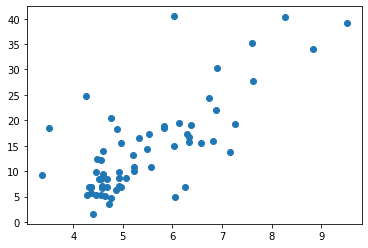

In [52]:
plt.figure()
plt.scatter(c.numpy(), l2.numpy())
plt.show()

In [53]:
features_original[0].shape, features_distorted[0].shape

((96, 128, 128), (96, 128, 128))

In [56]:
c[0], l2[0]

(<tf.Tensor: shape=(), dtype=float32, numpy=6.25581>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.9165606>)

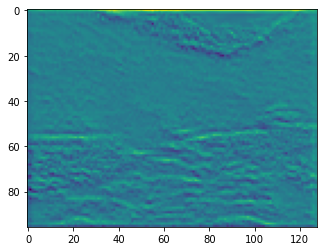

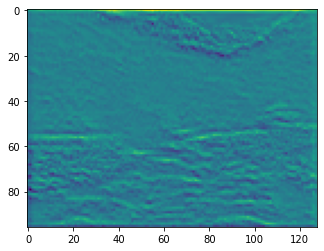

In [54]:
plt.figure()
plt.imshow(features_original[0].squeeze()[:,:,0])
plt.show()

plt.figure()
plt.imshow(features_distorted[0].squeeze()[:,:,0])
plt.show()

In [40]:
class PerceptNet(tf.keras.Model):
    def __init__(self):
        super(PerceptNet, self).__init__()
        self.model = tf.keras.Sequential([
            GDNJ(kernel_size=1, apply_independently=True, kernel_initializer="identity"),
            layers.Conv2D(filters=3, kernel_size=1, strides=1, padding='same'),
            layers.MaxPool2D(2),
            GDNJ(kernel_size=1, kernel_initializer="identity"),
            layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same'),
            layers.MaxPool2D(2),
            GDNJ(kernel_size=1, kernel_initializer="identity"),
            layers.Conv2D(filters=128, kernel_size=5, strides=1, padding='same'),
            GDNJ(kernel_size=1, kernel_initializer="identity")
        ])
    
    def call(self, X):
        return self.model(X)

    def train_step(self, data):
        """
        X: tuple (Original Image, Distorted Image)
        Y: float (MOS score)
        """
        img, dist_img, mos = data
        with tf.GradientTape() as tape:
            features_original = self(img)
            features_distorted = self(dist_img)
            features_original = layers.Flatten()(features_original)
            features_distorted = layers.Flatten()(features_distorted)
            l2 = tf.sqrt(tf.reduce_sum((features_original-features_distorted)**2, axis=-1))
            loss = -self.compiled_loss(mos, l2) # We want to maximize the Pearson Correlation, so we negate it
            loss = tf.reduce_mean(loss)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {'pearson':loss}


In [41]:
model = PerceptNet()

In [51]:
epochs = 1

for epoch in range(epochs):
    for img, dist_img, mos in dataset.batch(2):
        print(img.shape, dist_img.shape, mos.shape)
        with tf.GradientTape() as tape:
            features_original = model(img)
            features_distorted = model(dist_img)
            l2 = (features_original-features_distorted)**2
            l2 = tf.reduce_sum(l2, axis=[1,2,3])
            l2 = tf.sqrt(l2)
            loss = -PearsonCorrelation()(mos, l2)
        print(loss)
        gradients = tape.gradient(loss, model.trainable_variables)
        # break
    break

(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(1.0, shape=(), dtype=float32)
(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(1.0, shape=(), dtype=float32)
(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(1.0, shape=(), dtype=float32)
(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(1.0, shape=(), dtype=float32)
(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(-0.99999994, shape=(), dtype=float32)
(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(1.0, shape=(), dtype=float32)
(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(-1.0, shape=(), dtype=float32)
(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(1.0000001, shape=(), dtype=float32)
(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(-1.0000001, shape=(), dtype=float32)
(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(-1.0, shape=(), dtype=float32)
(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(0.9999999, shape=(), dtype=float32)
(2, 384, 512, 3) (2, 384, 512, 3) (2,)
tf.Tensor(-1.0, shape=(), dtype=float32)
(1, 384, 512, 3) (1, 3

In [43]:
l2

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.155274, 5.391365], dtype=float32)>

In [44]:
mos

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.53488, 5.68571], dtype=float32)>

In [45]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=-1.0000001>